# Table of Contents

1. [Business Understanding](#Business-Understanding)
2. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
3. [Data Preprocessing](#Data-Preprocessing)
4. [Model Building](#Model-Building)
5. [Productivization Plan](#Productivization-Plan)

In [106]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer

from sklearn.pipeline import Pipeline
from category_encoders import OrdinalEncoder, LeaveOneOutEncoder

from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.ensemble import StackingClassifier

# from tensorflow import keras
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import log_loss, accuracy_score, roc_auc_score, classification_report

import pickle


random_state = np.random.RandomState(1)
np.random.seed(1) # for reproducibility

# Business Understanding
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

Given a set of features, we are asked to <b>predict whether or not a given household is poor or not</b>. This is a <b>binary classification</b>, which specifically posits the following problem: what is the <b>probability</b> of a given household of being poor. This probability is actually the prediction value and the loss function measures the prediction performance. For a binary classification, the typical loss function is the binary cross-entropy or <b>log loss</b>. In this case, we shall output a file with the probability for each household (in test dataset) of being poor.<br>

Log Loss is a slight twist on the Likelihood Function. In fact, Log Loss is -1 * the log of the likelihood function. The likelihood function answers the question "how likely did the model think the actually observed set of outcomes was" and is computed iteratively stepping through all predictions by multiplying the probability associated with the actual outcome and subsequently by the previous result.<br>

Predictions range between 0 and 1, and their resulting multiplication gets so small that computers can't keep track of it. So, as a clever computational trick, we instead keep track of the log of the Likelihood. We multiply this by negative 1 to maintain a common convention that lower loss scores are better. Lower loss scores are associated with higher probabilities and viceversa.<br>

Since data is anonimized and no context information has been provided, no economic analysis on variables is possible. Let's now have some insights on the data.

# Exploratory Data Analysis
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

## Load Data

In [2]:
# Train dataset
data_train = pd.read_csv('../data/Exercise_train (1).csv', sep=',')
data_train.head()

,Unnamed: 0,id,kjkrfgld,bpowgknt,raksnhjf,vwpsxrgk,omtioxzz,yfmzwkru,tiwrsloh,weioazcf,poor
0,2225,29252,KfoTG,zPfZR,DtMvg,NaN,12.0,-3.0,-1.0,0.5,False
1,1598,98286,ljBjd,THHLT,DtMvg,esAQH,21.0,-2.0,-5.0,-9.5,True
2,7896,49040,Lsuai,zPfZR,zeYAm,ZCIYy,12.0,-3.0,-5.0,-9.5,True
3,1458,35261,KfoTG,mDadf,zeYAm,ZCIYy,12.0,-1.0,-5.0,-9.5,False
4,1817,98833,KfoTG,THHLT,DtMvg,ARuYG,21.0,-4.0,-5.0,-9.5,True


In [3]:
# Test dataset
data_test = pd.read_csv('../data/Exercise_test (1).csv', sep=',')
data_test.head()

,Unnamed: 0,id,kjkrfgld,bpowgknt,raksnhjf,vwpsxrgk,omtioxzz,yfmzwkru,tiwrsloh,weioazcf,poor
0,2197,42706,qzGkS,zPfZR,rXCdD,IJnCs,21.0,-3.0,-5.0,-9.5,False
1,4823,65531,KfoTG,THHLT,DtMvg,XHmQd,21.0,-2.0,-9.0,-19.5,True
2,4165,64452,tnDpM,THHLT,qTmDg,yygvO,30.0,-4.0,-9.0,-19.5,True
3,4962,78022,NaN,WXYiE,DtMvg,XAmOF,21.0,-2.0,3.0,10.5,False
4,4671,45674,Lsuai,zPfZR,DtMvg,hmAUm,30.0,-4.0,-5.0,-9.5,True


In [4]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6562 entries, 0 to 6561
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  6562 non-null   int64  
 1   id          6562 non-null   int64  
 2   kjkrfgld    6366 non-null   object 
 3   bpowgknt    6357 non-null   object 
 4   raksnhjf    6381 non-null   object 
 5   vwpsxrgk    6364 non-null   object 
 6   omtioxzz    6361 non-null   float64
 7   yfmzwkru    6353 non-null   float64
 8   tiwrsloh    6355 non-null   float64
 9   weioazcf    6366 non-null   float64
 10  poor        6562 non-null   bool   
dtypes: bool(1), float64(4), int64(2), object(4)
memory usage: 519.2+ KB


In [5]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1641 entries, 0 to 1640
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1641 non-null   int64  
 1   id          1641 non-null   int64  
 2   kjkrfgld    1595 non-null   object 
 3   bpowgknt    1592 non-null   object 
 4   raksnhjf    1605 non-null   object 
 5   vwpsxrgk    1596 non-null   object 
 6   omtioxzz    1587 non-null   float64
 7   yfmzwkru    1597 non-null   float64
 8   tiwrsloh    1601 non-null   float64
 9   weioazcf    1579 non-null   float64
 10  poor        1641 non-null   bool   
dtypes: bool(1), float64(4), int64(2), object(4)
memory usage: 129.9+ KB


In both datasets, we encounter:
<ul>
    <li> same number of non-null values in the columns Unnamed: 0 (supposedly, individuals <code>iid</code>) and households <code>id</code>, so that individuals analysis (or the size of a household) becomes irrelevant</li>
    <li> four possible categorical (nominal) variables represented as object (strings) with missing values both in train and in test (3% of each dataset approximately)</li>
    <li> four continuous variables represented as float, with missing values both in train and in test (3% of each dataset approximately)</li>
    <li> target variable represented as a boolean</li>
</ul>

#### No duplicates / Unique observations

In [17]:
column_names = [x for x in data_train.columns]
duplicates = data_train.duplicated(subset=column_names, keep=False)
data_train[duplicates]

,Unnamed: 0,id,kjkrfgld,bpowgknt,raksnhjf,vwpsxrgk,omtioxzz,yfmzwkru,tiwrsloh,weioazcf,poor


In [7]:
data_train.id.nunique() 

6562

In [9]:
column_names = [x for x in data_test.columns]
duplicates = data_test.duplicated(subset=column_names, keep=False)
data_test[duplicates]

,Unnamed: 0,id,kjkrfgld,bpowgknt,raksnhjf,vwpsxrgk,omtioxzz,yfmzwkru,tiwrsloh,weioazcf,poor


In [8]:
data_test.id.nunique()

1641

We now set the DataFrame's index to household's <code>id</code> for further analysis.

In [6]:
data_train = data_train.set_index('id')
data_test = data_test.set_index('id')

## Target

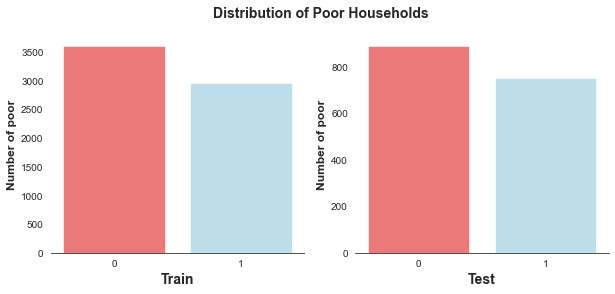

In [7]:
sns.set_style('white')
fig, axes = plt.subplots(1, 2, figsize = (10, 4))

# Create a countplot
sns.countplot(x='poor',
              data=data_train,
              order=[0, 1],
              # Set colour of hue and transperency
              palette = ["r","skyblue"],
              alpha = 0.6,
              ax=axes[0])

# Final styling touche
axes[0].set_ylabel("Number of poor", fontsize = 12, fontweight = "semibold")
axes[0].set_xlabel("Train", fontweight = "semibold", fontsize = 14)


# Create a countplot
sns.countplot(x='poor',
              data=data_test,
              order=[0, 1],
              # Set colour of hue and transperency
              palette = ["r","skyblue"],
              alpha = 0.6,
              ax=axes[1])

# Final styling touche
axes[1].set_ylabel("Number of poor", fontsize = 12, fontweight = "semibold")
axes[1].set_xlabel("Test", fontweight = "semibold", fontsize = 14)

# Despine visualizations
sns.despine(left=True)
fig.suptitle("Distribution of Poor Households", fontweight = "semibold", fontsize = 14)
plt.show()

## Numerical features

In [26]:
data_train.describe()

,Unnamed: 0,omtioxzz,yfmzwkru,tiwrsloh,weioazcf
count,6562.000000,6361.000000,6353.000000,6355.000000,6366.000000
mean,4113.757543,17.455117,-2.826696,-4.194335,-7.461828
std,2353.382080,10.924393,12.615775,4.476410,11.198626
min,0.000000,-127.000000,-4.000000,-31.000000,-74.500000
25%,2088.500000,12.000000,-4.000000,-7.000000,-14.500000
50%,4115.500000,12.000000,-3.000000,-3.000000,-4.500000
75%,6156.750000,21.000000,-2.000000,-1.000000,0.500000
max,8202.000000,111.000000,1000.000000,3.000000,10.500000


Text(0.5, 0, 'omtioxzz')

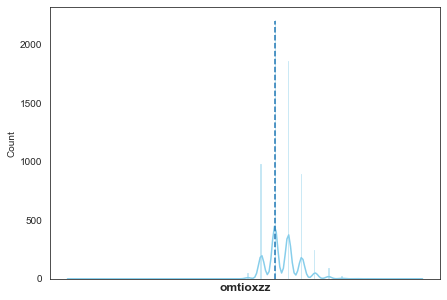

In [8]:
# Create plot of omtioxzz distribution
sns.set_style('white')
plt.figure(figsize=(7,5))
sns.histplot(data=data_train,
             x='omtioxzz',
             color = "skyblue",
             kde = True)

# Add vertical line and annotate median age for male employees
plt.axvline(data_train['omtioxzz'].median(), ymax = 0.95, linestyle = "--")
# Format subplot in axes
plt.xticks([])
plt.xlabel("omtioxzz", fontsize = 12, fontweight = "semibold")

Text(0.5, 0, 'yfmzwkru')

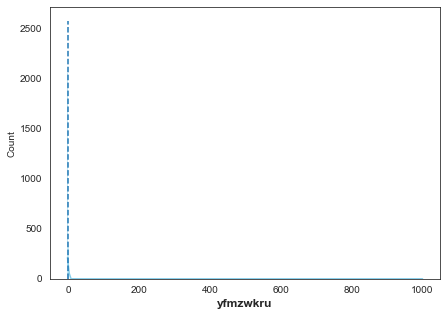

In [9]:
# Create plot of omtioxzz distribution
sns.set_style('white')
plt.figure(figsize=(7,5))
sns.histplot(data=data_train,
             x='yfmzwkru',
             color = "skyblue",
             kde = True,
             hue_norm=[-5, 100])

# Add vertical line and annotate median age for male employees
plt.axvline(data_train['yfmzwkru'].median(), ymax = 0.95, linestyle = "--")
# Format subplot in axes
#plt.xticks([])
plt.xlabel("yfmzwkru", fontsize = 12, fontweight = "semibold")

Text(0.5, 0, 'tiwrsloh')

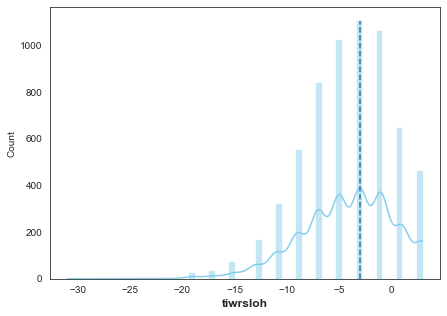

In [10]:
# Create plot of omtioxzz distribution
sns.set_style('white')
plt.figure(figsize=(7,5))
sns.histplot(data=data_train,
             x='tiwrsloh',
             color = "skyblue",
             kde = True)

# Add vertical line and annotate median age for male employees
plt.axvline(data_train['tiwrsloh'].median(), ymax = 0.95, linestyle = "--")
# Format subplot in axes
#plt.xticks([])
plt.xlabel("tiwrsloh", fontsize = 12, fontweight = "semibold")

Text(0.5, 0, 'weioazcf')

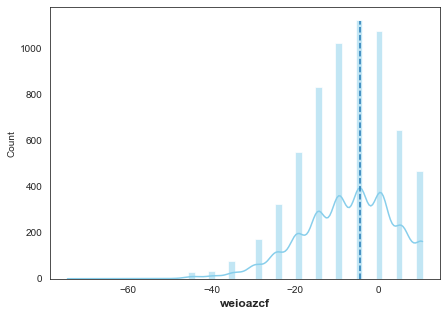

In [11]:
# Create plot of omtioxzz distribution
sns.set_style('white')
plt.figure(figsize=(7,5))
sns.histplot(data=data_train,
             x='weioazcf',
             color = "skyblue",
             kde = True)

# Add vertical line and annotate median age for male employees
plt.axvline(data_train['weioazcf'].median(), ymax = 0.95, linestyle = "--")
# Format subplot in axes
#plt.xticks([])
plt.xlabel("weioazcf", fontsize = 12, fontweight = "semibold")

Descriptive statistics of the four numerical variables uncover the following:
<ul>
    <li>skewed distributions,</li>
    <li>fat tails and presence of outliers</li>
</ul>

## Categorical features

### Low dimensional categorical variables

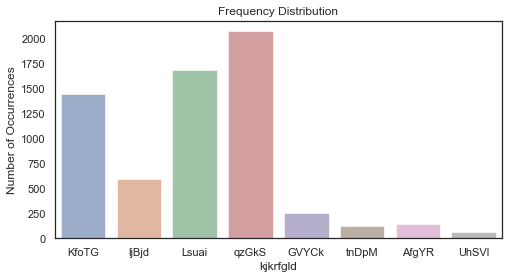

In [14]:
plt.figure(figsize = (8, 4))
sns.set(style="white")
sns.countplot(x='kjkrfgld', data=data_train, alpha=0.6)
plt.title('Frequency Distribution')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('kjkrfgld', fontsize=12)
plt.show()

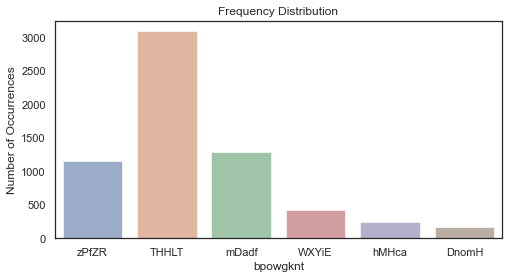

In [15]:
plt.figure(figsize = (8, 4))
sns.set(style="white")
sns.countplot(x='bpowgknt', data=data_train, alpha=0.6)
plt.title('Frequency Distribution')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('bpowgknt', fontsize=12)
plt.show()

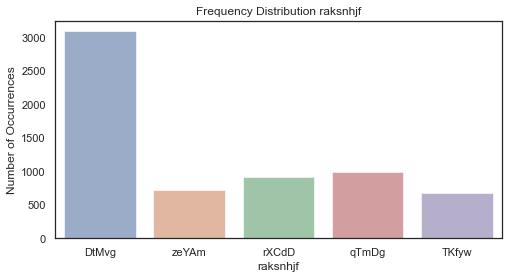

In [16]:
plt.figure(figsize = (8, 4))
sns.set(style="white")
sns.countplot(x='raksnhjf', data=data_train, alpha=0.6)
plt.title('Frequency Distribution raksnhjf')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('raksnhjf', fontsize=12)
plt.show()

### High dimensional categorical variable

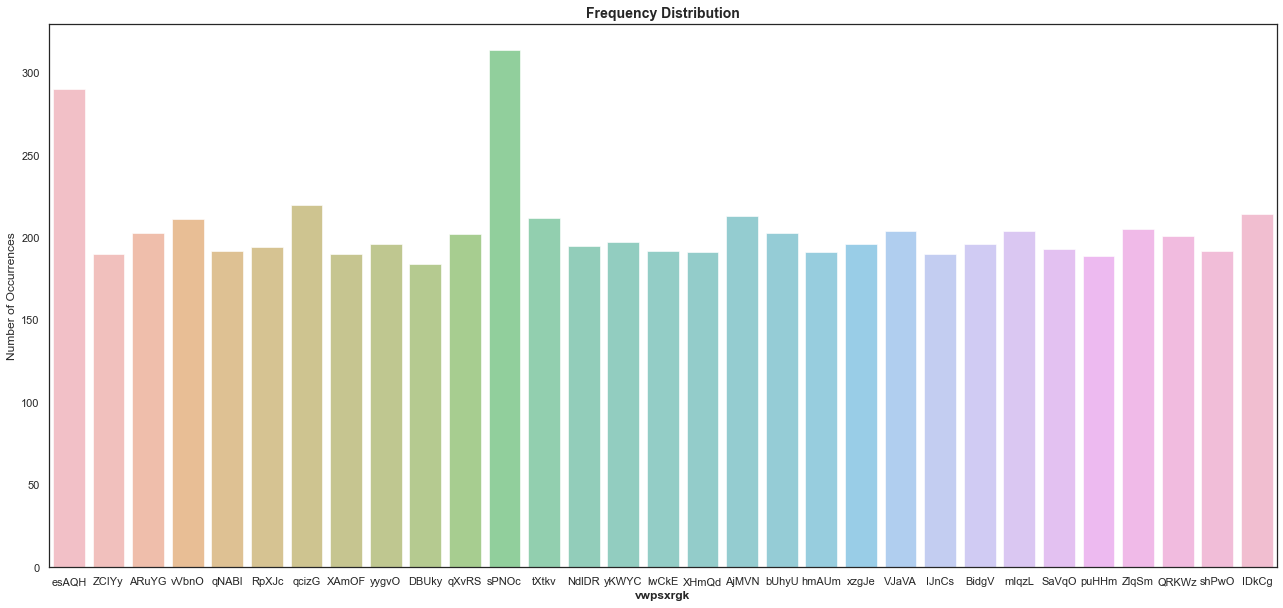

In [17]:
plt.figure(figsize = (22, 10))
sns.set(style="white")

sns.countplot(x='vwpsxrgk', data=data_train, alpha=0.6)

plt.title('Frequency Distribution', fontweight = "bold", fontsize = 14)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('vwpsxrgk', fontsize=12, fontweight = "semibold")
plt.show()

# Data Preprocessing
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

## Target preprocessing

Let's transform our target variable into a binary (0, 1) variable.

In [18]:
data_train['poor'] = data_train['poor'].apply(lambda x: 1 if x == True else 0)

In [19]:
data_test['poor'] = data_test['poor'].apply(lambda x: 1 if x == True else 0)

## Train, Test datasets

In [20]:
X_train = data_train.drop('poor', 1)
y_train = data_train['poor']

In [21]:
X_test = data_test.drop('poor', 1)
y_test = data_test['poor']

## Features preprocessing

In light of the above, some data preprocessing is needed.<br>

As of <b>numerical variables</b>, two steps need to be accomplished in a <b>pipeline</b>:
<ol>
    <li> <b>impute NAs</b> with a median strategy (to better account for non-normal distributions),</li>
    <li> <b>standardize variables</b> aiming at <i>normalizing</i> data distributions. We shall use PowerTransformer method, well suited for skewed distributions (and outliers?). Unscaled data can degrade the predictive performance of machine learning algorithms and slow down or even prevent the convergence of many gradient-based estimators.</li>
</ol>
    
[Documentation](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py)
<br>

Regarding <b>categorical variables</b>, any standard work-flow in feature engineering would typically involve some form of transformation of these categorical values into numeric labels and then applying some encoding scheme on these values (see <code>Prepa_Pover-T_Tests.ipynb</code> for a three-step <i>out-of-pipe</i> approach). However, in order to streamline the process, we will have recourse to a <i>column transform</i> method instead aiming at <b>simultaneously addressing NAs imputation and variable encoding</b>.<br>


We will opt for an <b>ordinal encoder</b> for those variables with a low dimensionality (and coincidentally, uneven frequency distribution among categories) and for a <b>target encoder</b> for the variable with a greater dimensionality. With target encoding, each category is replaced with the mean target value associated with that category. One of its main benefits is that it prevents the curse of dimensionality; as a drawback, it captures correlations with target values, thus incurring in overfitting. This should be carefully addressed by fitting some noise (sigma) in the model, as explained in the next section.<br>

For more information, read this [tutorial](https://www.datacamp.com/community/tutorials/categorical-data) and this [post](https://brendanhasz.github.io/2019/03/04/target-encoding).<br>

As such, the <b>preprocessor object</b> arquitecture consists of the following</b>:<br>

<ol>
    <li> <b>Pipeline</b> for NAs imputation and data scaling of <b>numerical features</b></li>
    <li> <b>Column Transformer</b> for variables (numerical and categorical encoding)</li>
</ol>

Check for reference this [video](https://www.youtube.com/watch?v=Ma-CDFLd03g) (1:17 min onwards).

In [22]:
# Categorical features: (i) ordinal encoder for low dimensionality categorical variables (which implicitely impute NAs)
low_dim_cat = ['kjkrfgld', 'bpowgknt', 'raksnhjf']
ordinal_enc = OrdinalEncoder()

# Categorical features (suite): (ii) target encoder for the high dimensionality categorical variable (it also tackles NAs imputation)
high_dim_cat = ['vwpsxrgk']
target_enc = LeaveOneOutEncoder()
    
# Numerical features: (i) impute NAs using median strategy, (ii) scale data using Power Transformer to properly address for skewed distributions and outliers
numeric_features = data_train.select_dtypes(include=['float64']).columns.copy()
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', PowerTransformer())])

# Preprocessor with a Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('ordinal_encoder', ordinal_enc, low_dim_cat),
        ('target_encoder', target_enc, high_dim_cat)])

# Model Building
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

## Baseline model: Logistic Regression

This is the classical function for a binary classification problem. We will use the results of this model as our baseline.

In [24]:
# Logistic Regression
clf_lr = LogisticRegression()
pipe_lr = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier',  clf_lr)])

# Fit the model
lr = pipe_lr.fit(X_train, y_train)

# Predict probabilities
y_pred_lr = pipe_lr.predict_proba(X_test)
log_loss(y_test, y_pred_lr, eps=1e-15, normalize=True, sample_weight=None, labels=None)


0.5165545774500514

## Random Forest Classifier

The second model to be used is a Random Forest Classifier. It works like this: (i) it selects random samples from a given dataset, (ii) it constructs a decision tree for each sample and gets a prediction result from each decision tree, (iii) it performs a vote for each predicted result, and (iv) it selects the prediction result with the most votes as the final prediction.<br>

We will additionally perform some hyperparameter tuning and cross-validation in order to get the best estimator.<br>

It should be noted that some noise for the target encoder will also be modelled, corresponding to sigma.

<b>Figure 1</b>: <b>Random Forest Model</b> (<i>source: Datacamp</i>)<br>
<p align="center">
<img src="../images/rf.png">
</p>
<br><br>

In [25]:
clf_rf = RandomForestClassifier()
pipe_rf = Pipeline([('preprocessor', preprocessor), ('classifier',  clf_rf)])

In [26]:
# Hyperparameters can be accessed with a double underscore
param_grid = {
    'preprocessor__target_encoder__sigma': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06],
    'classifier__bootstrap': [True],
    'classifier__max_depth': [80, 90, 100, 110],
    'classifier__max_features': [2, 3],
    'classifier__min_samples_leaf': [3, 4, 5],
#     'classifier__min_samples_split': [8, 10, 12],
    'classifier__n_estimators': [100, 200, 300, 1000]
}

rscv_rf = RandomizedSearchCV(pipe_rf,
                          cv=5,
                          n_iter=5,
                          n_jobs=10,
                          param_distributions = param_grid,
                          scoring='neg_log_loss',
                          random_state=1)


In [27]:
cross_val_score(pipe_rf, X_train, y_train, cv=5, scoring='neg_log_loss')

array([-0.55417663, -0.56779309, -0.59720809, -0.58862939, -0.64791177])

In [28]:
rf_fit = rscv_rf.fit(X_train, y_train)
rf_fit

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                PowerTransformer())]),
                                                                               Index(['omtioxzz', 'yfmzwkru', 'tiwrsloh', 'weioazcf'], dtype='object')),
                                                                              ('ordinal_encoder',
                                                                               OrdinalEncoder(),
                

In [29]:
rscv_rf.best_params_

{'preprocessor__target_encoder__sigma': 0.02,
 'classifier__n_estimators': 300,
 'classifier__min_samples_leaf': 4,
 'classifier__max_features': 2,
 'classifier__max_depth': 80,
 'classifier__bootstrap': True}

In [30]:
rscv_rf.best_score_

-0.4961307691653105

Metrics [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html#sklearn.metrics.log_loss)

In [31]:
y_pred_rf = rscv_rf.best_estimator_.predict_proba(X_test)
log_loss(y_test, y_pred_rf, eps=1e-15, normalize=True, sample_weight=None, labels=None)

0.49708334741130766

The scoring metric is slightly improved. 

## Gradient Boosting Methods

Gradient boosting refers to a class of ensemble machine learning algorithms. It <b>learns iteratively from a set of weak models on subsets of the data, weighing each weak prediction according to each weak learner's performance and combining the weighted predictions to obtain a single weighted prediction</b>. Models are fit using any arbitrary differentiable loss function and gradient descent optimization algorithm that allows the loss gradient being minimized with successive iterations.<br>

Here, we will fit three different GB methods: <b>CatBoost, Light Gradient Boosting and Extreme Gradient Boosting</b>. The structural diffierences among them are the following: CatBoost has the flexibility of giving indices of categorical columns so that it can be encoded as one-hot encoding using one_hot_max_size, whereas Light Gradient Boosting can handle categorical features by taking the input of feature names. It does not convert to one-hot coding, and is much faster than one-hot coding. LGBM uses a special algorithm to find the split value of categorical features. In turn, Extreme Gradient Boosting cannot handle categorical features by itself and only accepts numerical values. Therefore one has to perform various encodings before supplying categorical data to XGBoost.<br>

Notwithstanding, as categorical encoding has previously done in the preprocessor pipeline, we won't use any of these figures.

<b>Figure 2</b>: <b>Gradient Boosting Model</b> (<i>source: Medium</i>)<br>
<p align="center">
<img src="../images/gb.png">
</p>
<br><br>

### Extreme Gradient Boosting

[Hyperparameter tuning](https://xgboost.readthedocs.io/en/latest/parameter.html)

In [34]:
clf_xgb = XGBClassifier()
pipe_xgb = Pipeline([('preprocessor', preprocessor), ('classifier',  clf_xgb)])

In [37]:
# Hyperparameters can be accessed with a double underscore
param_grid_XGB = {
        'preprocessor__target_encoder__sigma': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06],
        'classifier__n_estimators': [100, 200, 300, 1000],
        'classifier__learning_rate' : [0.01, 0.02, 0.03],
        'classifier__max_depth' : [3, 4, 5],
        'classifier__objective' : ['binary:logistic', 'binary:logitraw'],
#         'classifier__silent' : True,
#         'classifier__gamma' : 0.3,
#         'classifier__subsample' : 0.7,
#         'classifier__reg_alpha' : 0.05
}

rscv_xgb = RandomizedSearchCV(pipe_xgb,
                          cv=5,
                          n_iter=5,
                          n_jobs=10,
                          param_distributions = param_grid_XGB,
                          scoring='neg_log_loss',
                          random_state=1)

In [38]:
xgb_fit = rscv_xgb.fit(X_train, y_train)
xgb_fit

/home/isabel/anaconda3/envs/DD_Pover-T_Tests/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:49:02] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                PowerTransformer())]),
                                                                               Index(['omtioxzz', 'yfmzwkru', 'tiwrsloh', 'weioazcf'], dtype='object')),
                                                                              ('ordinal_encoder',
                                                                               OrdinalEncoder(),
                

In [39]:
rscv_xgb.best_params_

{'preprocessor__target_encoder__sigma': 0.06,
 'classifier__objective': 'binary:logistic',
 'classifier__n_estimators': 300,
 'classifier__max_depth': 4,
 'classifier__learning_rate': 0.03}

In [40]:
rscv_xgb.best_score_

-0.4888701991105592

In [41]:
y_pred_xgb = rscv_xgb.best_estimator_.predict_proba(X_test)
log_loss(y_test, y_pred_xgb, eps=1e-15, normalize=True, sample_weight=None, labels=None)

0.49304486474365344

### Light Gradient Boosting

[Hyperparameter tunning](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)

In [42]:
clf_lgb = LGBMClassifier()
pipe_lgb = Pipeline([('preprocessor', preprocessor), ('classifier',  clf_lgb)])

In [43]:
# Hyperparameters can be accessed with a double underscore
param_grid_LGB = {
        'preprocessor__target_encoder__sigma': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06],
        'classifier__n_estimators': [100, 200, 300, 1000],
        'classifier__learning_rate' : [0.01, 0.02, 0.03],
        'classifier__max_depth' : [6, 7, 8],
        'classifier__l2_leaf_reg' : [3, 4, 5],
#         'classifier__loss_function' : 'Logloss',
#         'classifier__silent' : True,
#         'classifier__boosting_type' : 'gbdt',
#         'classifier__objective' : 'binary',
#         'classifier__gamma' : 0.3,
#         'classifier__subsample' : 0.6,
#         'classifier__reg_alpha' : 0.02,
#         'classifier__is_unbalance' : True,
#         'classifier__reg_lambda' : 0.01,
}

rscv_lgb = RandomizedSearchCV(pipe_lgb,
                          cv=5,
                          n_iter=5,
                          n_jobs=10,
                          param_distributions = param_grid_LGB,
                          scoring='neg_log_loss',
                          random_state=1)

In [44]:
lgb_fit = rscv_lgb.fit(X_train, y_train)
lgb_fit

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                PowerTransformer())]),
                                                                               Index(['omtioxzz', 'yfmzwkru', 'tiwrsloh', 'weioazcf'], dtype='object')),
                                                                              ('ordinal_encoder',
                                                                               OrdinalEncoder(),
                

In [45]:
rscv_lgb.best_params_

{'preprocessor__target_encoder__sigma': 0.02,
 'classifier__n_estimators': 300,
 'classifier__max_depth': 7,
 'classifier__learning_rate': 0.01,
 'classifier__l2_leaf_reg': 3}

In [46]:
rscv_lgb.best_score_

-0.4959588754947224

In [47]:
y_pred_lgb = rscv_lgb.best_estimator_.predict_proba(X_test)
log_loss(y_test, y_pred_lgb, eps=1e-15, normalize=True, sample_weight=None, labels=None)

0.49849568905505814

### CatBoost

Hyperparameters tunning [Documentation](https://catboost.ai/docs/concepts/python-reference_parameters-list.html)

In [48]:
clf_cb = CatBoostClassifier()
pipe_cb = Pipeline([('preprocessor', preprocessor), ('classifier',  clf_cb)])

In [49]:
# Hyperparameters can be accessed with a double underscore
param_grid_CB = {
        'preprocessor__target_encoder__sigma': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06],
        'classifier__n_estimators': [100, 200, 300, 1000],
        'classifier__learning_rate' : [0.01, 0.02, 0.03],
        'classifier__depth' : [6, 7, 8],
        'classifier__l2_leaf_reg' : [3, 4, 5],
#         'classifier__loss_function' : 'Logloss',
#         'classifier__logging_level' : 'Silent',
}

rscv_cb = RandomizedSearchCV(pipe_cb,
                          cv=5,
                          n_iter=5,
                          n_jobs=10,
                          param_distributions = param_grid_CB,
                          scoring='neg_log_loss',
                          random_state=1)

In [50]:
cb_fit = rscv_cb.fit(X_train, y_train)
cb_fit

0:	learn: 0.6891817	total: 51.1ms	remaining: 51s
1:	learn: 0.6853852	total: 54.5ms	remaining: 27.2s
2:	learn: 0.6816860	total: 57.7ms	remaining: 19.2s
3:	learn: 0.6778634	total: 61.3ms	remaining: 15.3s
4:	learn: 0.6740027	total: 65ms	remaining: 12.9s
5:	learn: 0.6705778	total: 68.8ms	remaining: 11.4s
6:	learn: 0.6671320	total: 72.7ms	remaining: 10.3s
7:	learn: 0.6638831	total: 76.4ms	remaining: 9.48s
8:	learn: 0.6607596	total: 80.2ms	remaining: 8.82s
9:	learn: 0.6575393	total: 83.9ms	remaining: 8.31s
10:	learn: 0.6543431	total: 87.7ms	remaining: 7.88s
11:	learn: 0.6514807	total: 91.4ms	remaining: 7.53s
12:	learn: 0.6483641	total: 95.2ms	remaining: 7.23s
13:	learn: 0.6457077	total: 99ms	remaining: 6.97s
14:	learn: 0.6426633	total: 103ms	remaining: 6.75s
15:	learn: 0.6398034	total: 107ms	remaining: 6.55s
16:	learn: 0.6374926	total: 110ms	remaining: 6.37s
17:	learn: 0.6348448	total: 114ms	remaining: 6.22s
18:	learn: 0.6322105	total: 118ms	remaining: 6.08s
19:	learn: 0.6295319	total: 122ms

240:	learn: 0.4771701	total: 657ms	remaining: 2.07s
241:	learn: 0.4769857	total: 664ms	remaining: 2.08s
242:	learn: 0.4768104	total: 668ms	remaining: 2.08s
243:	learn: 0.4766334	total: 673ms	remaining: 2.08s
244:	learn: 0.4765859	total: 675ms	remaining: 2.08s
245:	learn: 0.4763541	total: 678ms	remaining: 2.08s
246:	learn: 0.4762307	total: 680ms	remaining: 2.07s
247:	learn: 0.4760310	total: 682ms	remaining: 2.07s
248:	learn: 0.4758658	total: 684ms	remaining: 2.06s
249:	learn: 0.4756602	total: 686ms	remaining: 2.06s
250:	learn: 0.4755120	total: 689ms	remaining: 2.05s
251:	learn: 0.4753265	total: 691ms	remaining: 2.05s
252:	learn: 0.4751876	total: 693ms	remaining: 2.04s
253:	learn: 0.4750697	total: 695ms	remaining: 2.04s
254:	learn: 0.4748705	total: 697ms	remaining: 2.04s
255:	learn: 0.4747289	total: 699ms	remaining: 2.03s
256:	learn: 0.4744879	total: 701ms	remaining: 2.03s
257:	learn: 0.4743263	total: 703ms	remaining: 2.02s
258:	learn: 0.4742107	total: 705ms	remaining: 2.02s
259:	learn: 

421:	learn: 0.4534633	total: 1.05s	remaining: 1.44s
422:	learn: 0.4533646	total: 1.06s	remaining: 1.44s
423:	learn: 0.4532761	total: 1.06s	remaining: 1.44s
424:	learn: 0.4531895	total: 1.06s	remaining: 1.44s
425:	learn: 0.4530705	total: 1.07s	remaining: 1.44s
426:	learn: 0.4530217	total: 1.07s	remaining: 1.44s
427:	learn: 0.4529113	total: 1.07s	remaining: 1.43s
428:	learn: 0.4527609	total: 1.07s	remaining: 1.43s
429:	learn: 0.4526242	total: 1.08s	remaining: 1.43s
430:	learn: 0.4525665	total: 1.08s	remaining: 1.43s
431:	learn: 0.4524771	total: 1.08s	remaining: 1.42s
432:	learn: 0.4523791	total: 1.08s	remaining: 1.42s
433:	learn: 0.4522657	total: 1.09s	remaining: 1.42s
434:	learn: 0.4521526	total: 1.09s	remaining: 1.41s
435:	learn: 0.4520879	total: 1.09s	remaining: 1.41s
436:	learn: 0.4520214	total: 1.09s	remaining: 1.41s
437:	learn: 0.4519359	total: 1.09s	remaining: 1.4s
438:	learn: 0.4519064	total: 1.1s	remaining: 1.4s
439:	learn: 0.4518265	total: 1.1s	remaining: 1.4s
440:	learn: 0.451

597:	learn: 0.4393795	total: 1.45s	remaining: 974ms
598:	learn: 0.4392812	total: 1.45s	remaining: 974ms
599:	learn: 0.4392169	total: 1.46s	remaining: 973ms
600:	learn: 0.4391853	total: 1.46s	remaining: 971ms
601:	learn: 0.4391157	total: 1.46s	remaining: 968ms
602:	learn: 0.4390464	total: 1.47s	remaining: 966ms
603:	learn: 0.4389760	total: 1.47s	remaining: 963ms
604:	learn: 0.4389739	total: 1.47s	remaining: 960ms
605:	learn: 0.4388528	total: 1.47s	remaining: 957ms
606:	learn: 0.4388367	total: 1.47s	remaining: 955ms
607:	learn: 0.4387255	total: 1.48s	remaining: 952ms
608:	learn: 0.4386653	total: 1.48s	remaining: 949ms
609:	learn: 0.4385991	total: 1.48s	remaining: 947ms
610:	learn: 0.4385279	total: 1.48s	remaining: 944ms
611:	learn: 0.4384434	total: 1.48s	remaining: 941ms
612:	learn: 0.4383025	total: 1.49s	remaining: 938ms
613:	learn: 0.4382792	total: 1.49s	remaining: 936ms
614:	learn: 0.4382074	total: 1.49s	remaining: 933ms
615:	learn: 0.4381492	total: 1.49s	remaining: 930ms
616:	learn: 

783:	learn: 0.4265135	total: 1.85s	remaining: 509ms
784:	learn: 0.4264692	total: 1.85s	remaining: 508ms
785:	learn: 0.4264075	total: 1.86s	remaining: 506ms
786:	learn: 0.4263166	total: 1.86s	remaining: 504ms
787:	learn: 0.4262522	total: 1.86s	remaining: 501ms
788:	learn: 0.4261703	total: 1.86s	remaining: 499ms
789:	learn: 0.4261595	total: 1.87s	remaining: 496ms
790:	learn: 0.4261035	total: 1.87s	remaining: 494ms
791:	learn: 0.4260483	total: 1.87s	remaining: 492ms
792:	learn: 0.4260086	total: 1.87s	remaining: 489ms
793:	learn: 0.4259538	total: 1.88s	remaining: 487ms
794:	learn: 0.4259059	total: 1.88s	remaining: 484ms
795:	learn: 0.4258516	total: 1.88s	remaining: 482ms
796:	learn: 0.4257972	total: 1.88s	remaining: 479ms
797:	learn: 0.4257492	total: 1.88s	remaining: 477ms
798:	learn: 0.4256976	total: 1.89s	remaining: 475ms
799:	learn: 0.4256538	total: 1.89s	remaining: 472ms
800:	learn: 0.4255973	total: 1.89s	remaining: 470ms
801:	learn: 0.4255512	total: 1.89s	remaining: 467ms
802:	learn: 

962:	learn: 0.4148028	total: 2.24s	remaining: 86.2ms
963:	learn: 0.4147476	total: 2.25s	remaining: 83.9ms
964:	learn: 0.4146729	total: 2.25s	remaining: 81.6ms
965:	learn: 0.4146066	total: 2.25s	remaining: 79.3ms
966:	learn: 0.4145241	total: 2.26s	remaining: 77ms
967:	learn: 0.4144438	total: 2.26s	remaining: 74.7ms
968:	learn: 0.4143895	total: 2.26s	remaining: 72.4ms
969:	learn: 0.4143143	total: 2.26s	remaining: 70ms
970:	learn: 0.4142432	total: 2.27s	remaining: 67.7ms
971:	learn: 0.4141996	total: 2.27s	remaining: 65.3ms
972:	learn: 0.4141427	total: 2.27s	remaining: 63ms
973:	learn: 0.4140663	total: 2.27s	remaining: 60.7ms
974:	learn: 0.4139895	total: 2.27s	remaining: 58.3ms
975:	learn: 0.4139141	total: 2.28s	remaining: 56ms
976:	learn: 0.4138739	total: 2.28s	remaining: 53.7ms
977:	learn: 0.4138349	total: 2.28s	remaining: 51.3ms
978:	learn: 0.4137624	total: 2.28s	remaining: 49ms
979:	learn: 0.4136615	total: 2.29s	remaining: 46.6ms
980:	learn: 0.4135633	total: 2.29s	remaining: 44.3ms
981

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                PowerTransformer())]),
                                                                               Index(['omtioxzz', 'yfmzwkru', 'tiwrsloh', 'weioazcf'], dtype='object')),
                                                                              ('ordinal_encoder',
                                                                               OrdinalEncoder(),
                

In [51]:
rscv_cb.best_params_

{'preprocessor__target_encoder__sigma': 0.02,
 'classifier__n_estimators': 1000,
 'classifier__learning_rate': 0.01,
 'classifier__l2_leaf_reg': 3,
 'classifier__depth': 7}

In [52]:
rscv_cb.best_score_

-0.48435994526086584

In [53]:
y_pred_cb = rscv_cb.best_estimator_.predict_proba(X_test)
log_loss(y_test, y_pred_cb, eps=1e-15, normalize=True, sample_weight=None, labels=None)

0.4888258706732481

## Ensembling Models

Ensembling is a method of combining base models and is based on the hypothesis that a much more powerful model can be produced by combining multiple models together. There are different types of ensembling techniques, such as:<br>
<ul>
    <li> Bagging: Short for Bootstrap Aggregation, uses bootstrap sampling to obtain data subsets for training ‘base learners’ and reduces variance.</li>
    <li> Boosting: Converts ‘weak learners’ (models that are slightly better than guessing) to strong learners and reduces bias.</li>
    <li> Stacking: Combines multiple models via a meta-model and improves predictions.</li>
</ul>

So far, we have used bagging method (random forest) and boosting methods (xgb, lgb and cb). Here, we shall explore the <b>stacking method</b>.

<b>Figure 3</b>: <b>Stacking Model</b> (<i>source: [Datacamp](https://www.datacamp.com/resources/webinars/applied-machine-learning-stacking-ensemble-models?utm_medium=email&utm_source=customerio&utm_campaign=livetraining&utm_id=3679156))</i>)<br>
<p align="center">
<img src="https://github.com/datacamp/Applied-Machine-Learning-Ensemble-Modeling-live-training/blob/master/assets/stacking.png?raw=True" alt = "Stacking" width="90%">
</p>
<br><br>

Check [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html) for more information.

In [55]:
estimators = [
    ('rf', rscv_rf.best_estimator_),
    ('xgb', rscv_xgb.best_estimator_),
    ('lgb', rscv_lgb.best_estimator_),
    ('cb', rscv_cb.best_estimator_)
]

clf_stack = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression(), cv=5, stack_method='predict_proba', n_jobs=-1
)

clf_stack = clf_stack.fit(X_train, y_train)

In [56]:
y_pred_stack = clf_stack.predict_proba(X_test)
log_loss(y_test, y_pred_stack, eps=1e-15, normalize=True, sample_weight=None, labels=None)

0.49728560488626633

## A Neural Network model for binary classification

This neural network consists of three layers:
<ul>
    <li>an <b>input layer</b> consisting of two neurons (binary target variable)</li>
    <li>a <b>hidden layer</b> with a shape of four neurons using a tangent activation function, which tends to yield a smooth separation among the two classes. LeakyRElu might also work well,</li>
    <li>an <b>output layer</b> with one neuron with a sigmoid activation function, well suited for binary classification problems as appreciated in its graphical representation.The sigmoid activation function squashes the output of the previous layer into a floating point between zero and one, as the probability of a pair of coordinates of being in one class or another considering a certain threshold</li>
</ul>

Check this DataCamp [course](https://learn.datacamp.com/courses/deep-learning-with-keras-in-python) for more information.<br>

However, the neural network could not be fitted as an unresolved <i>Attribute error</i> pops up while importing tensorflow / keras libraries ([GitHub issue](https://github.com/tensorflow/tensorflow/issues/38012)). Unfortunately, this solution (python 3.6) is not valid for python 3.8.

<b>Figure 4</b>: <b>Neural Network</b> (<i>source: Datacamp</i>)<br>
<p align="center">
<img src="../images/nn.png">

<b>Figure 5</b>: <b>Sigmoid function</b> (<i>source: Datacamp</i>)<br>
<p align="center">
<img src="../images/sigmoid.png">

In [119]:
# Function that creates a Keras model
def create_model(optimizer='sgd', activation='tanh'):
    model = Sequential()
    model.add(Dense(4, input_shape=(2,), activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy')
    return model
    
# Create a model a sklearn estimator
model = KerasClassifier(build_fn=create_model, epochs=6, batch_size=16)
    
# Plug the model into the pipeline
pipe = Pipeline([('column_transform', column_trans), ('classifier', model)])
    
# Random search on a Keras model
params = dict(optimizer=['sgd', 'adam'], epochs=3,
              batch_size=[5, 10, 20], activation=['tanh', 'LeakyReLU']
              
rscv_nn = RandomizedSearchCV(pipe, params_dist=params, cv=3)
              
# Model fit
rscv_nn.fit(X_train, y_train)
              
rscv_nn.best_scores_
rscv_nn.best_params_
              

SyntaxError: invalid syntax (<ipython-input-119-252077236823>, line 19)

In [ ]:
# Model test
y_pred_nn = model.predict_proba(X_test)

test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy: {}, Test loss: {}'.format(test_acc, test_loss))

## Best Model's (CatBoost) results interpretation

The best performing model is CatBoost although in general, results have been very tight. There is still a long way to improve results with hyperparameter tuning, feature selection and model ensembling.

In [57]:
y_pred_cb

array([[0.58400283, 0.41599717],
       [0.46280789, 0.53719211],
       [0.36480348, 0.63519652],
       ...,
       [0.93143536, 0.06856464],
       [0.30099356, 0.69900644],
       [0.58575231, 0.41424769]])

### Results

In [58]:
index = data_test.reset_index().id
results = pd.DataFrame(index=index)
results['poor'] = y_pred_cb[:, 1]

In [59]:
results.tail()

,poor
id,
30092,0.752361
38226,0.405828
36893,0.068565
97193,0.699006
83638,0.414248


In [60]:
results.to_csv('../model/results.csv')

#### How to interpret results

Read the following [medium post](https://medium.com/@fzammito/whats-considered-a-good-log-loss-in-machine-learning-a529d400632d#:~:text=The%20bolder%20the%20probabilities%2C%20the,distinguish%20more%20strongly%20the%20classes).<br>

In a binary classification problem (N = 2) for balanced classes (every class has the same prevalence), the equation is the following:
\begin{equation*}Logloss = -log(\frac{1}{2})\end{equation*}<br>

equalling 0.693, in which case, 0.4888 might seem a good scoring.<br>

However, classes in this problem are unbalanced (with a possible prevalence of 85% of poor households over non-poor ones). In such case, a good scoring would have to lie between 0.50 and 0.33, all the more so since the winners of this competition got 0.1447.<br>

Let's check some other interesting metrics for the case.

#### Other interesting metrics for binary classification (not accounting for probabilities)

In [85]:
accuracy_score(y_test,rscv_cb.predict(X_test))

0.7452772699573431

In [95]:
from sklearn.metrics import classification_report, roc_curve, auc

In [90]:
print(classification_report(y_test,rscv_cb.predict(X_test)))

              precision    recall  f1-score   support

           0       0.76      0.78      0.77       891
           1       0.73      0.70      0.72       750

    accuracy                           0.75      1641
   macro avg       0.74      0.74      0.74      1641
weighted avg       0.74      0.75      0.74      1641



In [105]:
fp,tp,_ = roc_curve(y_test, rscv_cb.predict(X_test))

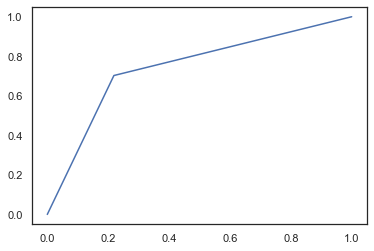

In [104]:
plt.plot(fp,tp);

In [98]:
auc(fp,tp)

0.7419057239057238

The results are well balanced (accuracy, precision and recall) and the scoring may be reputed acceptable but there is still room for improvement.

### Visualization

In [61]:
poor = pd.DataFrame(index=index)
poor['False'] = y_pred_cb[:, 0]
poor['True'] = y_pred_cb[:, 1]

In [62]:
poor.head()

,False,True
id,,
42706,0.584003,0.415997
65531,0.462808,0.537192
64452,0.364803,0.635197
78022,0.994575,0.005425
45674,0.485812,0.514188


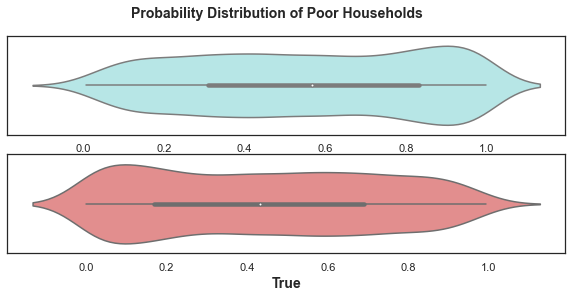

In [80]:
sns.set_style('white')
fig, axes = plt.subplots(2, 1, figsize = (10, 4))

sns.violinplot(x=poor["False"],
               color='paleturquoise',
               ax=axes[0])

axes[0].set_xlabel("False", fontweight = "semibold", fontsize = 14)                 

sns.violinplot(x=poor["True"],
               color='lightcoral',
               ax=axes[1])

axes[1].set_xlabel("True", fontweight = "semibold", fontsize = 14)

fig.suptitle("Probability Distribution of Poor Households", fontweight = "semibold", fontsize = 14)
plt.show()

fig.savefig('../images/results.png', dpi=fig.dpi)

The model predicts a greater number of poor households with low degrees of probability and viceversa. The contrary holds true for non-poor households.

# Productivization Plan
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

After building a model in lab conditions, we shall export a copy of it to the production server, where new data will be labelled. This process is called model deployment or pushing to production. To enable this, we shall serialize our model, that is, convert it to a binary file with pickle.<br>

As proceeded, we encapsulate the whole process into a single object (pipeline) to interact with production otherwise we will be forced to repeat one or various processes in production. Our aim is to avoid bugs which can eventually cause financial problems.

<b>Figure 6</b>: <b>Model Deployment</b> (<i>source: [Datacamp](https://learn.datacamp.com/courses/designing-machine-learning-workflows-in-python)</i>)<br>
<p align="center">
<img src="../images/model_deployment.png">

Save pickle file in write mode.

In [67]:
with open('../model/model.pkl', 'wb') as file:
    pickle.dump(rscv_cb.best_estimator_, file=file)

Load pickle file in read mode.

In [68]:
with open('../model/model.pkl', 'rb') as file:
    clf2 = pickle.load(file)